In [59]:
using Pkg, Revise
Pkg.activate("../.")
using BasicBSpline
using StaticArrays
using Plots
using LinearAlgebra
gr()

  Activating project at `~/MEGA/EMAP/Julia_Tutorials`


Plots.GRBackend()

## Curves Representation

The most general representation of a curve is just a set of points given by $(x,f(x))$, where
$f$ is a function. The problem with this formulation is that it depends on the coordinate system
used in order to draw the curve. Also, one has to "manually" define the number of discrete points
that will be used to approximate the curve drawing, and the quality of the approximation
depends on the coordinate system considered.

Another limitation of this representation is that one cannot represent objects
such as circles, since there is no function $f(x)$ that defines a circle.

This representation is known as explicit. Another possibility is an implicit one, where a
curve is given by an equation, e.g. $f(x,y) = 0$. In this representation,
we can represent circles, e.g. $(x-a)^2 + (y-b)^2 - r^2 =0$.

The implicit representation is good, yet, it's difficult to work with. For example, it's not clear how
to graph a point, since one does not know if the given point indeed solves the equation.

Perhaps the most useful representation is the parametric representation. A complicated curve
in the plane can be graphed using $\gamma:I \to \mathbb R^2$, e.g.
$\gamma(t) = cos(2\pi t) + sin (2\pi t)$. This parametric curve defines the circunference.

Now, there are many possible ways to parametrize the same curve. 

### Differential Geometry

The parametric definition of a curve is useful, but, since different parametrizations
can be used for the same curve, it'd be nice to have a way to group parametrizations
in equivalent classes, such that each class would indeed represent a single curve.

This can be done with the definition of a regular parametrization.

**Def.** A parametric representation $\gamma$ is regular if for all $t \in I$,
* $\gamma(t) \in C^1$,
* $\gamma'(t) \neq 0$.

**Def.** Given a parametric curve $\gamma:I_1 \to \mathbb R^3$, a parameter change is a bijective function
$p:I_2 \to I_1$. A parameter change is *regular* if $p(u) \in C^1$ for every $u \in I_2$ and
$p'(u) \neq 0$.

We say that two regular curves are equivalent if there is a regular parameter change between them.
This forms an equivalent class of regular curves.

Note that in our parametric curves, the parameter $t$ functions as a time parameter, where as time evolves,
we construct our curve. Thus, the derivative $\gamma'(t)$ can be thought of as the velocity
at time $t$. If the "velocity" of our parametrization has norm constant and equal to 1, we say
that it's an "arc length" parametrization, i.e. $||\gamma'(t)|| = 1$.
In this parametrization, $\gamma(t_2) - \gamma(t_1) = t_2 - t_1$ is equal to the length.

Regular curves with the arc length parametrization can be characterized by two scalar functions, called torsion and curvature.
These two functions are enough to describe the regular curves, meaning, if two curves
have the same torsion and curvature, they are the same curve (up to translation in space).

### Bézier Curves

The positive features of Bézier curves are the variation diminishing property, the convex hull
property, and the straightforward constructive algorithm.

The following algorithm defines the behaviour of Bézier curves.

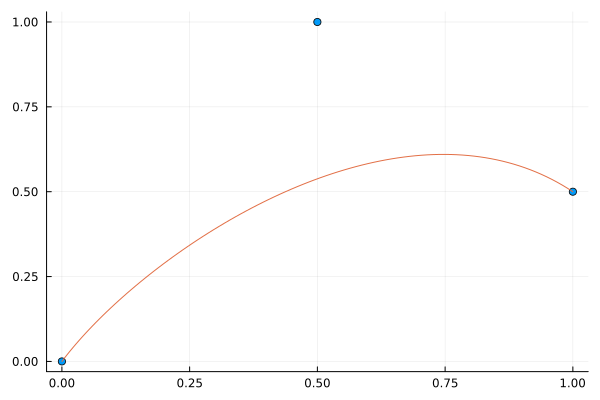

In [64]:
function bezier(t,pts)
    P = copy(pts)
    n = length(P)
    for j in 2:length(P)
        for i in j:n
            P[i] = (1-t)*P[i-1] + t*P[i]
        end
    end
    return P[n]
end

P = [[0.,0.],[0.5,1.0],[1.,0.5]]

p = reduce(hcat,P)'

γ = hcat([bezier(t, P) for t in 0:0.01:1]...)'

scatter(p[:,1],p[:,2],legend=false)
plot!(γ[:,1],γ[:,2])

The same algorithm can be written in recursive form as the following: 

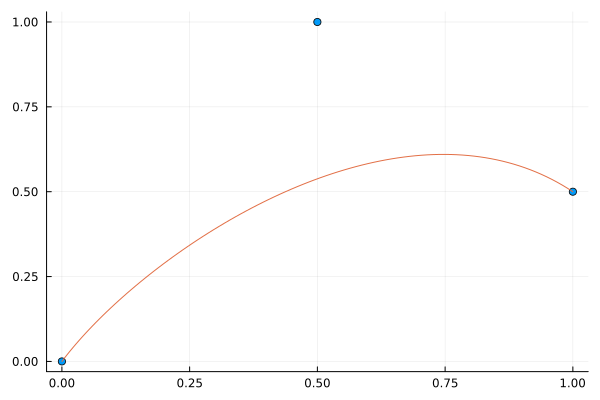

In [65]:
function bezier(t, pts::NTuple)
    p = bezier(t, pts[1:(end - 1)])
    q = bezier(t, pts[2:end])
    return p*(1-t) + t*q
end

function bezier(t, pts::NTuple{2})
    return pts[1]*(1-t) + t*pts[2]
end

scatter(p[:,1],p[:,2],legend=false)
γ = hcat([bezier(t, P) for t in 0:0.01:1]...)'
plot!(γ[:,1],γ[:,2])

The Bézier curve can actually be defined as a combination of basis functions, which as called the Bernstein bleding functions.

For $n+1$ control points, the Bernstein bleding functions associated to the Bézier curve are:
$$
\theta_{i,n}(t) := {n\choose i}(1-t)^{n-i}t^i,
$$
where the $i \in \{0,...,n\}$ index is the index associated to the control point $P_i$.

For example, in the case of three control points, i.e. $n=2$, the Bézier curve is the following:

In [82]:
θ₀(t) = (1-t)^2
θ₁(t) = 2(1-t) * t
θ₂(t) = t^2

θ₂ (generic function with 1 method)

These are the Bernstein functions. 

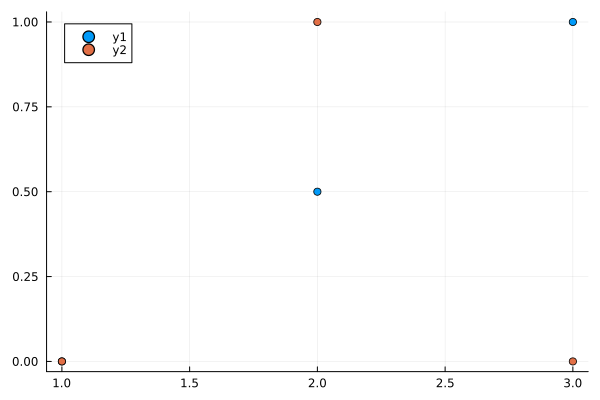

In [101]:
t = 0:0.01:1
p1 = plot(t,θ₀.(t))
p1 = plot!(t,θ₁.(t))
p1 = plot!(t,θ₂.(t))
xlims!(0,1)
ylims!(0,1)

p = [[0.,0.],[0.5,1.0],[1.0,0.0]]
beziercurve(t,p) = p[1]*θ₀(t) + p[2]*θ₁(t) + p[3]*θ₂(t)
curve = reduce(hcat,beziercurve.(t,Ref(p)))'

p = reduce(hcat,p)'
p2 = plot(curve[:,1], curve[:,2])

scatter(p[:,1],p[:,2],legend=false)
p2 = scatter(p)
# plot(p1,p1)

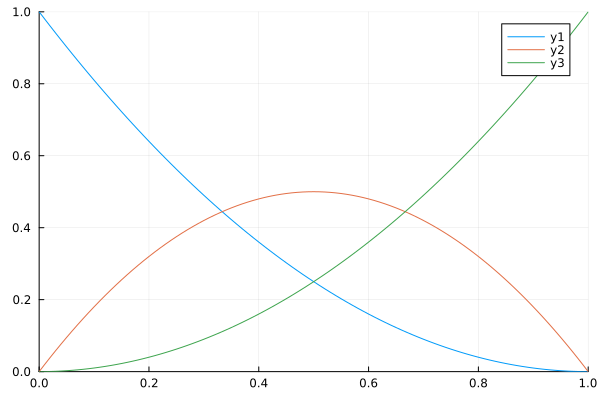

## B-Splines

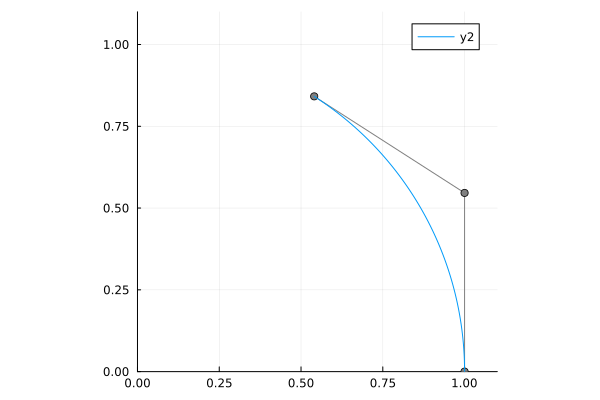

In [62]:
p = 2
k = KnotVector([0,0,0,1,1,1])
P = BSplineSpace{p}(k)
t = 1  # angle in radians
a = [SVector(1,0), SVector(1,tan(t/2)), SVector(cos(t),sin(t))]
w = [1,cos(t/2),1]
M = RationalBSplineManifold(a,w,P)
plot(M, xlims=(0,1.1), ylims=(0,1.1), aspectratio=1)

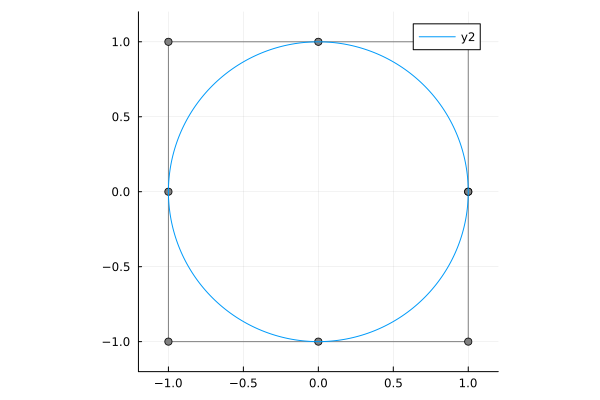

In [63]:
p = 2
k = KnotVector([0,0,0,1,1,2,2,3,3,4,4,4])
P = BSplineSpace{p}(k)
a = [
    SVector( 1, 0),
    SVector( 1, 1),
    SVector( 0, 1),
    SVector(-1, 1),
    SVector(-1, 0),
    SVector(-1,-1),
    SVector( 0,-1),
    SVector( 1,-1),
    SVector( 1, 0)
]
w = [1,1/√2,1,1/√2,1,1/√2,1,1/√2,1]
M = RationalBSplineManifold(a,w,P)
plot(M, xlims=(-1.2,1.2), ylims=(-1.2,1.2), aspectratio=1)